
# Gradient Boosting Visualized Step-by-Step

## Introduction 
Gradient Boosting is one of the most used ensemble machine learning techniques, for both regression and classification. This model uses an sequence of weak Decision Trees to build a strong learner. 
In this post we will be building a gradient boosting model from scratch and visualizing it.


### Algorithm Explained
We have a dataset of features $x_i$ and values $y_i$
We want to compute $F(x) = \mathbb{E}[y|x]$, the best estimation of y, given x.  

We start with $F_0 = \frac{1}{N}\sum_{i=1}^N y_i$ the mean of the y values.
At every step we want F_m(x) a better approximation of y|x.

$$D = {(x_i,y_i), i \in 1,...,N}$$

At every step we want $F_m(x)$ a better approximation of y given x.

First, we define a loss function, for example, Sum of Squared Residuals:  $$L(x)=(y-Fm(x)^2$$.

Then, we take a step in the direction of steepest descent for the loss function with respect to the Learner $Fm$:
$$ g_m(x) = -\frac{\partial{L}}{\partial{F_m(x)}}(y,F_m(x)) = y-F_m(x)$$

The problem is, we do not know the exact value of this gradient, since we cannot compute y for every x. 

However, for every $x_i$ in the training data, the gradient is exactly equal to the residual for step m : $r_i$!

Thus we can approximate the gradient function $g_m$ with a weak regression tree $h_m$, trained over the residuals:

$$D_{res} = {(x_i,  y_i - F_{m-1}(x_i)), i \in 1,...,N}$$

Then, we update the learner $$F_{m+1} = F_m + \alpha h_m$$

This is Gradient Boosting, instead of updating our current learner F_{m} using the true gradient g_m of the loss function with respect to this current learner, we update it with a weak regression tree $h_m$. 


## Pseudo-Code
$$F_0 = arg min_{\gamma} L(\gamma,Y) = \frac{1}{N}\sum_{i=1}^N y_i $$ cst value
Repeat, for step m: 
1.  Compute residuals:
$$r_i = y_i - F_{m-1}(x_i), i \in 1,...,N$$
2. Fit regression tree $h_m$ over the training samples and their residuals (x_i, r_i)
3. Update the model with step size $\alpha$
$$F_m = F_{m-1} + \alpha h_m $$


## Let's Code it from scratch ! 
We'll be trying this classifier on the moons dataset from sklearn. 

In [85]:
import numpy as np
import sklearn.datasets as ds
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import tree
from itertools import product,islice
import seaborn as sns 


In [86]:
moonDS = ds.make_moons(200, noise = 0.15, random_state=16)
moon = moonDS[0]
color = -1*(moonDS[1]*2-1)

df =pd.DataFrame(moon, columns = ['x','y'])
df['z'] = color
df['f0'] =df.y.mean()
df['r0'] = df['z'] - df['f0']
df.head(10)



,x,y,z,f0,r0
0,0.985425,-0.526577,-1,0.232734,-1.232734
1,0.888722,0.004503,1,0.232734,0.767266
2,1.763366,-0.118523,-1,0.232734,-1.232734
3,-0.280279,0.804625,1,0.232734,0.767266
4,0.330227,0.407421,-1,0.232734,-1.232734
5,1.485087,-0.345736,-1,0.232734,-1.232734
6,-0.340231,0.956424,1,0.232734,0.767266
7,1.008516,0.328819,1,0.232734,0.767266
8,0.401420,0.792921,1,0.232734,0.767266
9,0.716188,0.560657,1,0.232734,0.767266


[-1  1]


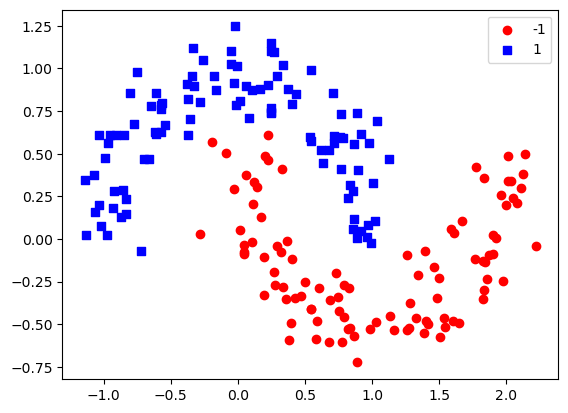

In [87]:
markers = ['o','s']
colors = ['r','b']
print(df.z.unique())
for i,cl in enumerate(df.z.unique()):
    plt.scatter(moon[df.z==cl,0],moon[df.z==cl,1], color = colors[i], marker= markers[i], label = cl)
plt.legend()


Tree Split for 1 and level -0.0025969967246055603


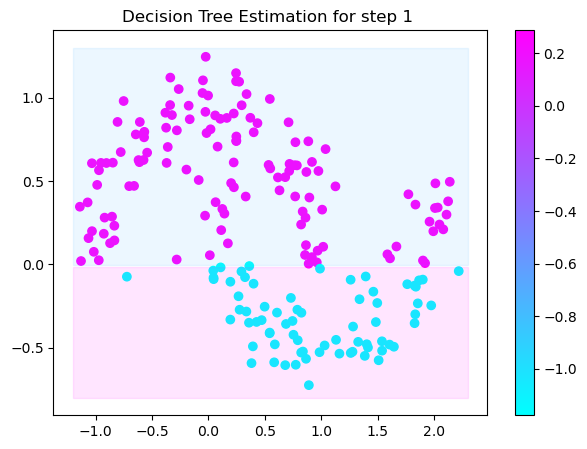

Tree Split for 0 and level 1.563690960407257


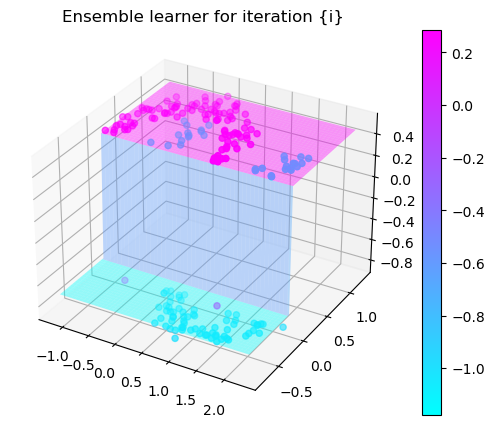

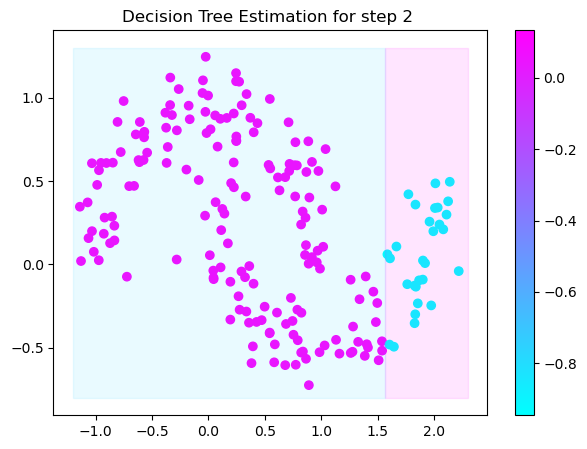

Tree Split for 1 and level 0.5143677890300751


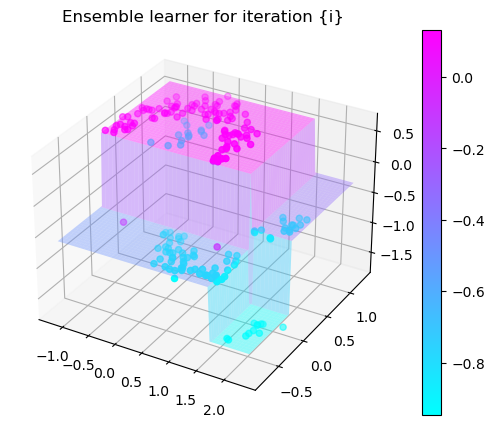

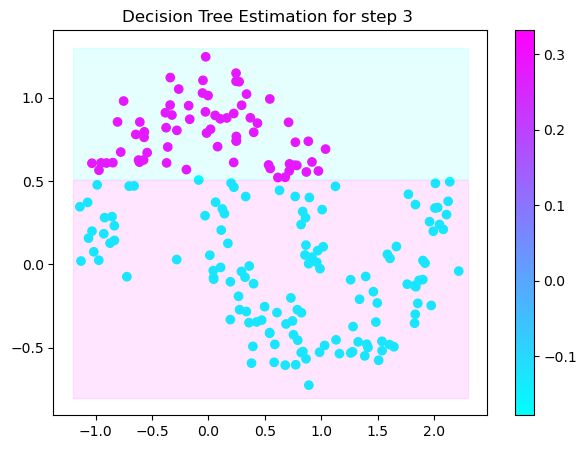

Tree Split for 0 and level -0.6523728966712952


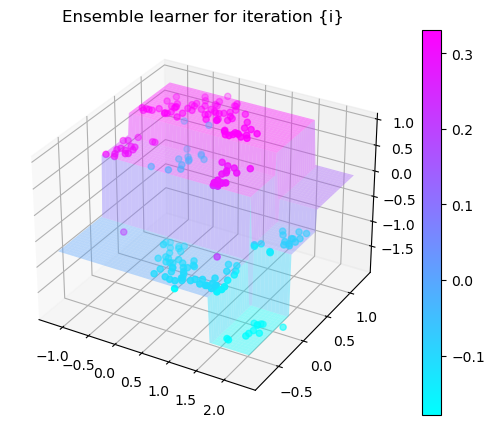

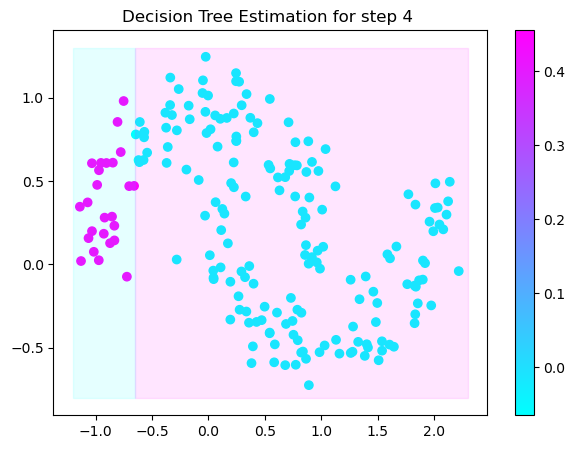

Tree Split for 0 and level 0.3370491564273834


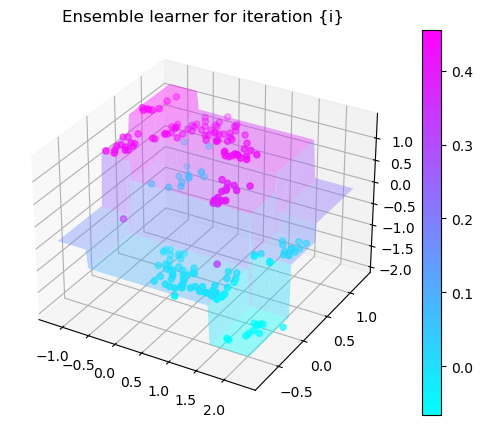

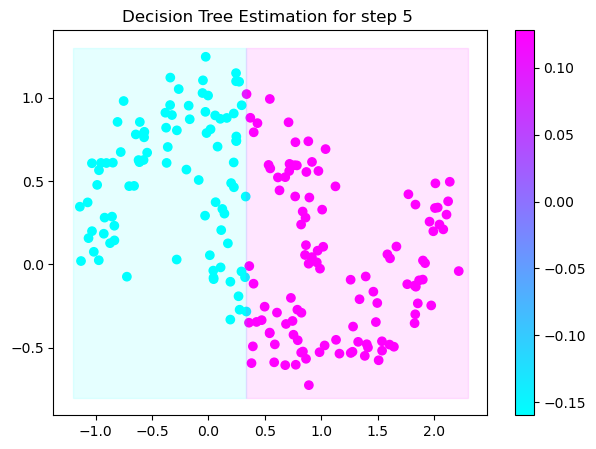

Tree Split for 1 and level 0.6128378212451935


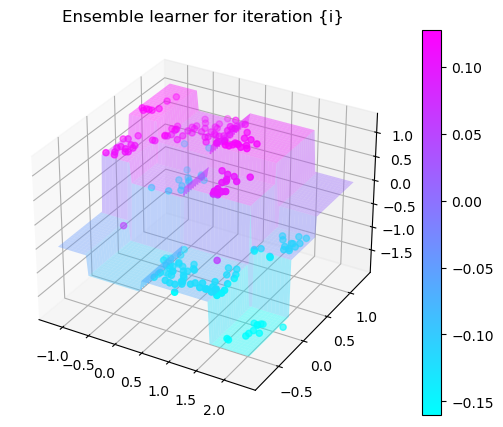

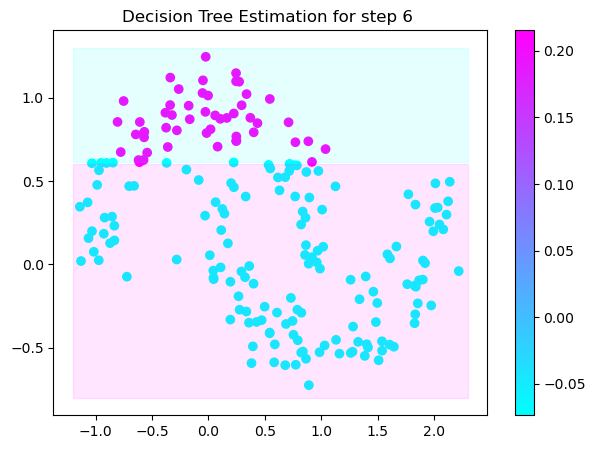

Tree Split for 1 and level 0.022058885544538498


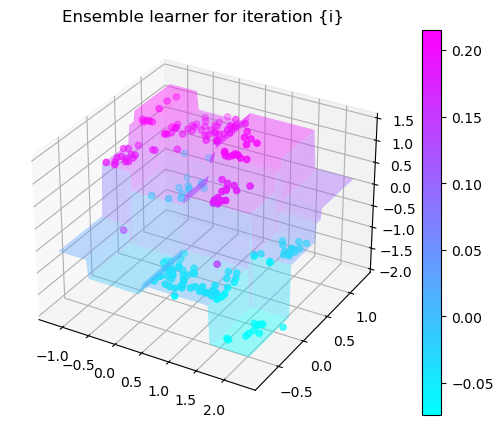

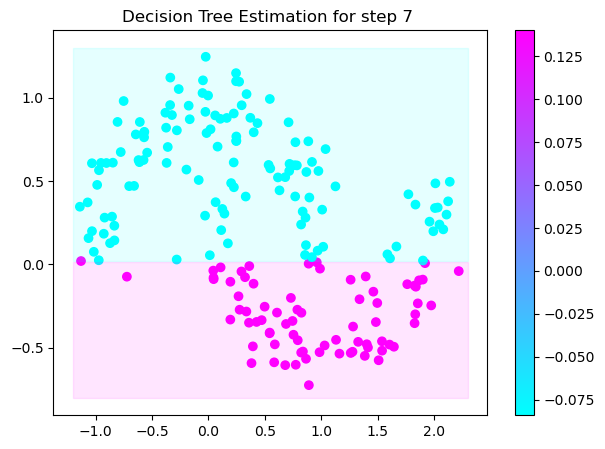

Tree Split for 0 and level -0.3030575215816498


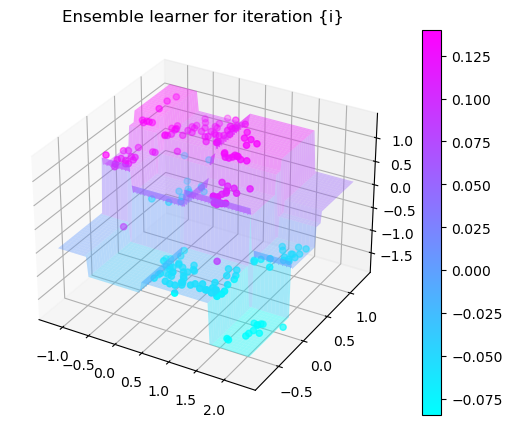

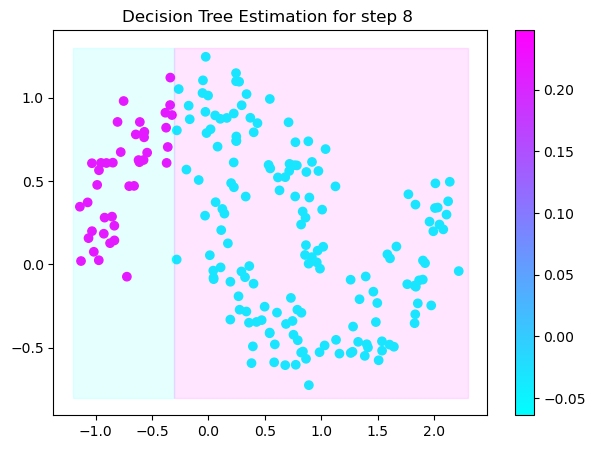

Tree Split for 0 and level 0.6119407713413239


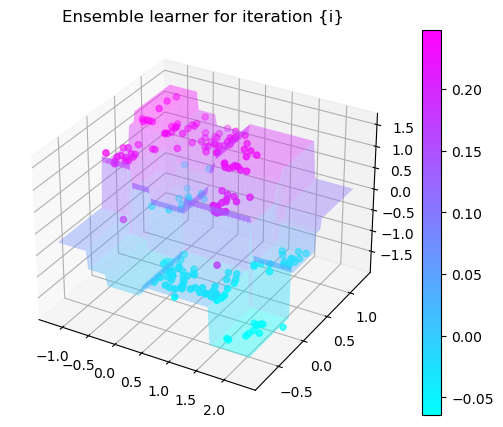

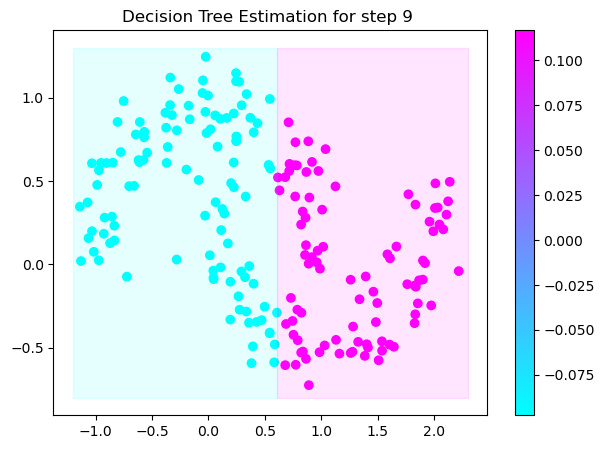

[DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1)]

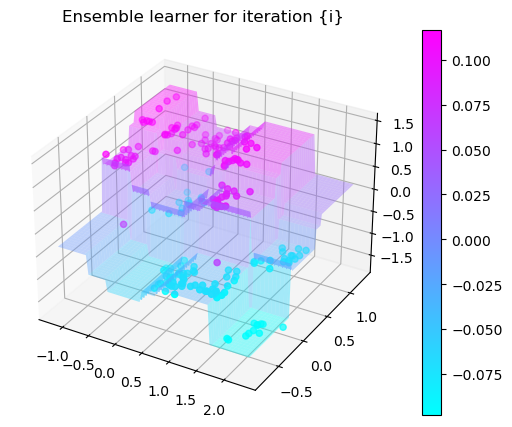

In [94]:

def makeiteration(i:int):
    """Takes the dataframe ith f_i and r_i and approximated r_i from the features, then computes f_i+1 and r_i+1"""
    clf = tree.DecisionTreeRegressor(max_depth=1)
    clf.fit(X=df[['x','y']].values, y = df[f'r{i-1}'])
    df[f'r{i-1}hat'] = clf.predict(df[['x','y']].values)

    #find best eta
    etas = np.linspace(0.01,0.9,20)
    dfetas = pd.DataFrame()
    dfetas['etas'] = etas
    rmse_mat = df.z.values - df[f'f{i-1}'].values - etas.reshape((20,1))*df[f'r{i-1}hat'].values**2 #Shape (20,200)
    dfetas['rmse'] = (rmse_mat.sum(axis =1))
    
    eta = 0.9
    grad = - (df.z - df[f'f{i-1}'] - eta*df[f'r{i-1}hat']) @ (df[f'r{i-1}hat'])
    df[f'f{i}'] = df[f'f{i-1}'] + eta*df[f'r{i-1}hat']
    df[f'r{i}'] = df['z'] - df[f'f{i}']
    rmse = (df[f'r{i}']**2).sum()
    clfs.append(clf)
    rmses.append(rmse)


def plotiteration(i):
    clf = clfs[-1]
    eta = 0.8
    xmin, xmax = -1.2, 2.3
    ymin, ymax = -0.8,1.3
    #plot the residual estimation
    fig = plt.figure(figsize = (7,5))
    norm = mpl.colors.Normalize(vmin=df[f'r{i-1}hat'].min(), vmax=df[f'r{i-1}hat'].max())
    plt.scatter(df['x'], df['y'], c =  df[f'r{i-1}hat'], cmap = 'cool')
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='cool'), ax=plt.gca())
    plt.title(f'Decision Tree Estimation for step {i} ')
    feat = clf.tree_.feature[0]
    ts = clf.tree_.threshold[0]
    print(f"Tree Split for {feat} and level {ts}")
    if feat == 0:
        shade1 = [xmin,ts,ts, xmin]
        shade2 = [ts,xmax,xmax,ts]
        shadey = [ymin, ymin,ymax, ymax]
        plt.fill(shade1,shadey, alpha = 0.1, color = plt.get_cmap('cool')(norm(pred[-1])))
        plt.fill(shade2,shadey, alpha = 0.1, color = plt.get_cmap('cool')(norm(pred[1])))
    if feat == 1:
        shadex = [xmin,xmin,xmax, xmax]
        shade1 = [ymax, ts,ts, ymax]
        shade2 = [ymin, ts-0.01,ts-0.01, ymin]
        plt.fill(shadex,shade1, alpha = 0.1, color = plt.get_cmap('cool')(norm(pred[-1])))
        plt.fill(shadex,shade2, alpha = 0.1, color = plt.get_cmap('cool')(norm(pred[1])))
    plt.show()

    #plot the total learner
    xabs = np.linspace(xmin,xmax, 100)
    yabs = np.linspace(ymin,ymax,100)
    X,Y = np.meshgrid(xabs,yabs)
    XY = product(xabs,yabs)
    mat = np.array([*XY])
    predList = [clf.predict(mat) for clf in clfs]
    predtotal = df.f0.iloc[0]
    for k in range(len(predList)):
        predtotal += eta*predList[k]
    Z = np.transpose([predtotal[i*100:i*100+100] for i in range(100)])
    plt.figure(figsize = (7,5))
    ax = plt.axes(projection = '3d')
    ax.scatter3D(df.loc[df.z==1,'x'], df.loc[df.z==1,'y'], df.loc[df.z==1, f"f{i}"], c = df.loc[df.z==1, 'z'], marker = 'o', cmap = 'cool', norm = norm )
    ax.scatter3D(df.loc[df.z==-1,'x'], df.loc[df.z==-1,'y'], df.loc[df.z==-1, f"f{i}"], c = df.loc[df.z==-1, 'z'], marker = 'o', cmap = 'cool', norm = norm)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='cool'), ax=ax)
    ax.plot_surface(X,Y,Z, cmap = 'cool', alpha = 0.4)
    ax.set(title = 'Ensemble learner for iteration {i}')
    return rmse, clfs


rmses = []
clfs = []
for k in range(1,10):
    makeiteration(k)
    plotiteration(k)



### Commentary 
The learners are all very simple decision trees, with just one split along one of the features! 
But the overal model is increasingly complex, and the overall error gradually decreases. 



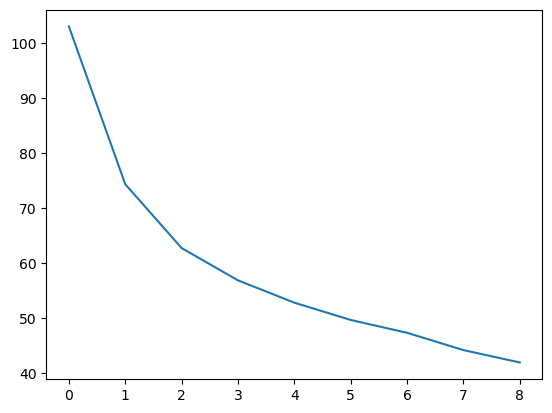

In [96]:
plt.plot(rmses)